In [137]:
import os
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from PIL import ImageFile


ImageFile.LOAD_TRUNCATED_IMAGES = True

torch.manual_seed(777)  # reproducibility

# parameters
total_dog_classes = 133
learning_rate = 0.001
batch_size = 10
keep_prob = 0.7
data_dir="../all_images/dogImages/"
TRAIN = 'train'
VAL = 'valid'
TEST = 'test'


# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),    
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
                  TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

image_datasets = {x: dsets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in [TRAIN, VAL, TEST]}



dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=10,
                                             shuffle=True, num_workers=0)
              for x in [TRAIN, VAL, TEST]}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}
class_names = image_datasets[TRAIN].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("number of training images:", len(image_datasets[TRAIN]))
print("numbe of validation images:", len(image_datasets[VAL]))
print("number of testing images:", len(image_datasets[TEST]))

number of training images: 6680
numbe of validation images: 835
number of testing images: 836


In [138]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
import numpy as np
import torch.optim as optim
import math
import argparse
from typing import Any, Callable, Optional, Tuple

import torch
from torch.autograd import Function
from torch.nn.modules.utils import _pair

class GoogLeNet1(nn.Module):
    def __init__(self,aux_logits=True, num_classes=total_dog_classes, init_weights=True):
        super(GoogLeNet1, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)

        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x 

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)


class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가합니다. 정규화 효과가 있습니다. 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
    
model_scratch = GoogLeNet1()
print(model_scratch)

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()

GoogLeNet1(
  (conv1): conv_block(
    (conv_layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (conv_layer): Sequential(
      (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (conv_layer): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (branch2): Sequential(


In [139]:
import warnings
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, Tuple, List, Callable, Any

__all__ = ['GoogLeNet2', 'googlenet', "GoogLeNetOutputs", "_GoogLeNetOutputs"]

model_urls = {
    # GoogLeNet ported from TensorFlow
    'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
}

GoogLeNetOutputs = namedtuple('GoogLeNetOutputs', ['logits', 'aux_logits2', 'aux_logits1'])
GoogLeNetOutputs.__annotations__ = {'logits': Tensor, 'aux_logits2': Optional[Tensor],
                                    'aux_logits1': Optional[Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _GoogLeNetOutputs set here for backwards compat
_GoogLeNetOutputs = GoogLeNetOutputs

class GoogLeNet2(nn.Module):
    __constants__ = ['aux_logits', 'transform_input']

    def __init__(
        self,
        num_classes = total_dog_classes,
        aux_logits = True,
        transform_input = False,
        init_weights = None,
        blocks = None
    ):
        super(GoogLeNet2, self).__init__()
        if blocks is None:
            blocks = [BasicConv2d, Inception, InceptionAux]
        if init_weights is None:
            warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(blocks) == 3
        conv_block = blocks[0]
        inception_block = blocks[1]
        inception_aux_block = blocks[2]

        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes)
            self.aux2 = inception_aux_block(528, num_classes)
        else:
            self.aux1 = None  # type: ignore[assignment]
            self.aux2 = None  # type: ignore[assignment]

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                import scipy.stats as stats
                X = stats.truncnorm(-2, 2, scale=0.01)
                values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
                values = values.view(m.weight.size())
                with torch.no_grad():
                    m.weight.copy_(values)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def _forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1: Optional[Tensor] = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2: Optional[Tensor] = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux2: Tensor, aux1: Optional[Tensor]) -> GoogLeNetOutputs:
        if self.training and self.aux_logits:
            return _GoogLeNetOutputs(x, aux2, aux1)
        else:
            return x   # type: ignore[return-value]

    def forward(self, x: Tensor) -> GoogLeNetOutputs:
        x = self._transform_input(x)
        x, aux1, aux2 = self._forward(x)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted GoogleNet2 always returns GoogleNetOutputs Tuple")
            return GoogLeNetOutputs(x, aux2, aux1)
        else:
            return self.eager_outputs(x, aux2, aux1)


class Inception(nn.Module):

    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Inception, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            # Here, kernel_size=3 instead of kernel_size=5 is a known bug.
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1)
        )

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = F.dropout(x, 0.7, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x


class BasicConv2d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)
    
model_scratch2 = GoogLeNet2()
print(model_scratch2)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    model_scratch2.cuda()
else:
    print("cuda is not available.")

<ipython-input-139-dd223fd75581>:39: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


GoogLeNet2(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, trac

In [140]:
import torch.optim as optim
from torch.optim import lr_scheduler
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size = 7, gamma=0.1)
optimizer_scratch2 = optim.SGD(model_scratch2.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_scratch2, step_size = 7, gamma=0.1)

In [142]:
import matplotlib.pyplot as plt
from PIL import ImageFile
import numpy as np
import time
import copy

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm
import torch

batch_size = 10
train_data = image_datasets[TRAIN]
test_data = image_datasets[TEST]
# dataloaders
train_data_loader = dataloaders[TRAIN]
valid_data_loader = dataloaders[VAL]

# training function
def fit(model, dataloader, optimizer, criterion, train_data, device, use_amp):
    print('Training')
    if use_amp == 'yes':
        scaler = torch.cuda.amp.GradScaler() 
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(train_data)/batch_size)):
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        
        if use_amp == 'yes':
            with torch.cuda.amp.autocast():
                outputs = model(image)
                loss = criterion(outputs[0], target)
        
        elif use_amp == 'no':
            outputs = model(image)
            loss = criterion(outputs[0], target)
            
        train_running_loss += (1/(i+1))*(loss.item() - train_running_loss)
        _, preds = torch.max(outputs[0], 1)
        train_running_correct += (preds == target).sum().item()
        
        if use_amp == 'yes':
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        elif use_amp == 'no':
            loss.backward()
            optimizer.step()
        
    train_loss = train_running_loss/dataset_sizes[TRAIN]
    train_accuracy = 100. * train_running_correct/dataset_sizes[TRAIN]    
    return train_loss, train_accuracy

# validation function
def validate(model, dataloader, optimizer, criterion, val_data, device, use_amp):
    print('Validating')
    if use_amp == True:
        scaler = torch.cuda.amp.GradScaler() 
        
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, (image,target) in tqdm(enumerate(dataloader), total=int(len(val_data)/batch_size)):
            image, target = image.to(device), target.to(device)
            
            if use_amp == 'yes':
                with torch.cuda.amp.autocast():
                    outputs = model(image)
                    loss = criterion(outputs, target)
        
            elif use_amp == 'no':
                outputs = model(image)
                loss = criterion(outputs, target)
            
            val_running_loss += (1/(i+1))*(loss.item() - val_running_loss)
            _, preds = torch.max(outputs, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/dataset_sizes[VAL]
        val_accuracy = 100. * val_running_correct/dataset_sizes[VAL]        
        return val_loss, val_accuracy
    
def train(epochs, model, criterion, optimizer, scheduler):
    since = time.time()
     
    train_loss = [[],[]]
    train_acc = [[],[]]
    val_loss = [[],[]]
    val_acc = [[],[]]

    use_amp = input("Do you want to use amp? (yes/no)")
    if use_amp == 'yes':
        print('Tranining and validating with Automatic Mixed Precision')
    else:
        print('Tranining and validating without Automatic Mixed Precision')
    
    start = time.time()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1} of {epochs}")
        for i,(j,k) in enumerate(zip(model,optimizer)):
            train_epoch_loss, train_epoch_accuracy = fit(j, train_data_loader, 
                                                         k, criterion, 
                                                         train_data, device, use_amp)
            val_epoch_loss, val_epoch_accuracy = validate(j, valid_data_loader, 
                                                         k, criterion, 
                                                         test_data, device, use_amp)
            train_loss[i].append(train_epoch_loss)
            train_acc[i].append(train_epoch_accuracy)
            val_loss[i].append(val_epoch_loss)
            val_acc[i].append(val_epoch_accuracy)
            print(f"Model{i+1} Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
            print(f"Model{i+1} Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}")
    end = time.time()
    print(f"Took {((end-start)/60):.3f} minutes to train for {epochs} epochs")

    # save model checkpoint
    for i in range(2):
        torch.save({
                    'epoch': epochs,
                    'model_state_dict': model[i].state_dict(),
                    'optimizer_state_dict': optimizer[i].state_dict(),
                    'loss': criterion,
                    }, f"./graphs/googLeNet_amp_{use_amp}_model{i+1}.pt")
    # accuracy plots
    plt.figure(figsize=(10, 7))
    for i in range(2):
        plt.plot(train_acc[i], color='green', label=f'Model{i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.savefig(f"./graphs/googLeNet_amp_{use_amp}_train_accuracy.png")
    plt.show()
    
    # accuracy plots
    plt.figure(figsize=(10, 7))
    for i in range(2):
        plt.plot(val_acc[i], color='blue', label=f'Model{i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.savefig(f"./graphs/googLeNet_amp_{use_amp}_val_accuracy.png")
    plt.show()

    # loss plots
    plt.figure(figsize=(10, 7))
    for i in range(2):
        plt.plot(train_loss[i], color='orange', label=f'Model{i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.savefig(f"./graphs/googLeNet_amp_{use_amp}_train_loss.png")
    plt.show()
    
    # loss plots
    plt.figure(figsize=(10, 7))
    for i in range(2):
        plt.plot(val_loss[i], color='red', label=f'Model{i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.savefig(f"./graphs/googLeNet_amp_{use_amp}_val_loss.png")
    plt.show()

Do you want to use amp? (yes/no)yes


  0%|          | 0/668 [00:00<?, ?it/s]

Tranining and validating with Automatic Mixed Precision
Epoch 1 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.85it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 1/668 [00:00<01:47,  6.20it/s]

Model1 Train Loss: 0.0007, Train Acc: 1.51
Model1 Val Loss: 0.0057, Val Acc: 1.56
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0007, Train Acc: 2.38
Model2 Val Loss: 0.0057, Val Acc: 2.40
Epoch 2 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.53it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.11it/s]

Model1 Train Loss: 0.0007, Train Acc: 2.47
Model1 Val Loss: 0.0054, Val Acc: 3.59
Training


  1%|          | 1/83 [00:00<00:14,  5.56it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0007, Train Acc: 4.01
Model2 Val Loss: 0.0051, Val Acc: 4.07
Epoch 3 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.32it/s]

Validating


84it [00:11,  7.23it/s]                        
  0%|          | 1/668 [00:00<01:59,  5.57it/s]

Model1 Train Loss: 0.0007, Train Acc: 3.52
Model1 Val Loss: 0.0052, Val Acc: 5.03
Training


  1%|          | 1/83 [00:00<00:09,  9.10it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0007, Train Acc: 4.61
Model2 Val Loss: 0.0051, Val Acc: 5.99
Epoch 4 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:34,  7.04it/s]

Model1 Train Loss: 0.0007, Train Acc: 4.06
Model1 Val Loss: 0.0051, Val Acc: 4.79
Training


  1%|          | 1/83 [00:00<00:10,  7.87it/s]

Validating


84it [00:11,  7.50it/s]                        
  0%|          | 1/668 [00:00<02:12,  5.03it/s]

Model2 Train Loss: 0.0006, Train Acc: 5.24
Model2 Val Loss: 0.0048, Val Acc: 7.90
Epoch 5 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.82it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.62it/s]

Model1 Train Loss: 0.0007, Train Acc: 4.97
Model1 Val Loss: 0.0050, Val Acc: 6.83
Training


  1%|          | 1/83 [00:00<00:11,  7.40it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 6.60
Model2 Val Loss: 0.0046, Val Acc: 8.86
Epoch 6 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0006, Train Acc: 5.73
Model1 Val Loss: 0.0049, Val Acc: 7.43
Training


  1%|          | 1/83 [00:00<00:08,  9.20it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 7.57
Model2 Val Loss: 0.0046, Val Acc: 9.94
Epoch 7 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.44it/s]

Validating


84it [00:11,  7.24it/s]                        
  0%|          | 1/668 [00:00<02:00,  5.55it/s]

Model1 Train Loss: 0.0006, Train Acc: 5.90
Model1 Val Loss: 0.0047, Val Acc: 9.10
Training


  1%|          | 1/83 [00:00<00:11,  6.89it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.24it/s]

Model2 Train Loss: 0.0006, Train Acc: 8.83
Model2 Val Loss: 0.0044, Val Acc: 11.26
Epoch 8 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.74it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:50,  6.01it/s]

Model1 Train Loss: 0.0006, Train Acc: 7.10
Model1 Val Loss: 0.0046, Val Acc: 9.34
Training


  2%|▏         | 2/83 [00:00<00:07, 11.26it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 10.19
Model2 Val Loss: 0.0045, Val Acc: 12.10
Epoch 9 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.49it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 1/668 [00:00<02:02,  5.46it/s]

Model1 Train Loss: 0.0006, Train Acc: 8.26
Model1 Val Loss: 0.0046, Val Acc: 9.94
Training


  1%|          | 1/83 [00:00<00:10,  8.00it/s]

Validating


84it [00:11,  7.47it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 10.58
Model2 Val Loss: 0.0040, Val Acc: 17.96
Epoch 10 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.43it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0006, Train Acc: 9.01
Model1 Val Loss: 0.0044, Val Acc: 10.90
Training


  1%|          | 1/83 [00:00<00:10,  7.66it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 12.16
Model2 Val Loss: 0.0041, Val Acc: 15.45
Epoch 11 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.99it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:44,  6.39it/s]

Model1 Train Loss: 0.0006, Train Acc: 10.37
Model1 Val Loss: 0.0044, Val Acc: 14.73
Training


  1%|          | 1/83 [00:00<00:09,  8.95it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0006, Train Acc: 12.60
Model2 Val Loss: 0.0040, Val Acc: 18.32
Epoch 12 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.11it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0006, Train Acc: 11.18
Model1 Val Loss: 0.0043, Val Acc: 12.57
Training


  1%|          | 1/83 [00:00<00:10,  7.79it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 13.98
Model2 Val Loss: 0.0039, Val Acc: 18.92
Epoch 13 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.46it/s]

Validating


84it [00:11,  7.16it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.61it/s]

Model1 Train Loss: 0.0006, Train Acc: 12.02
Model1 Val Loss: 0.0040, Val Acc: 17.13
Training


  2%|▏         | 2/83 [00:00<00:07, 10.34it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:06,  5.25it/s]

Model2 Train Loss: 0.0005, Train Acc: 16.02
Model2 Val Loss: 0.0036, Val Acc: 23.71
Epoch 14 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.00it/s]

Validating


84it [00:11,  7.20it/s]                        
  0%|          | 1/668 [00:00<01:54,  5.83it/s]

Model1 Train Loss: 0.0006, Train Acc: 12.31
Model1 Val Loss: 0.0041, Val Acc: 16.29
Training


  2%|▏         | 2/83 [00:00<00:07, 10.59it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 16.65
Model2 Val Loss: 0.0037, Val Acc: 23.83
Epoch 15 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.09it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.18it/s]

Model1 Train Loss: 0.0005, Train Acc: 13.40
Model1 Val Loss: 0.0040, Val Acc: 19.64
Training


  1%|          | 1/83 [00:00<00:08,  9.58it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 18.10
Model2 Val Loss: 0.0036, Val Acc: 26.59
Epoch 16 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.32it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0005, Train Acc: 13.79
Model1 Val Loss: 0.0040, Val Acc: 19.16
Training


  2%|▏         | 2/83 [00:00<00:06, 11.91it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 19.52
Model2 Val Loss: 0.0035, Val Acc: 24.67
Epoch 17 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.39it/s]

Model1 Train Loss: 0.0005, Train Acc: 15.94
Model1 Val Loss: 0.0038, Val Acc: 21.92
Training


  1%|          | 1/83 [00:00<00:08,  9.28it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 21.32
Model2 Val Loss: 0.0034, Val Acc: 27.78
Epoch 18 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.39it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0005, Train Acc: 17.11
Model1 Val Loss: 0.0039, Val Acc: 20.96
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 22.28
Model2 Val Loss: 0.0033, Val Acc: 28.38
Epoch 19 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.11it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:44,  6.38it/s]

Model1 Train Loss: 0.0005, Train Acc: 17.89
Model1 Val Loss: 0.0040, Val Acc: 22.28
Training


  1%|          | 1/83 [00:00<00:11,  7.32it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0005, Train Acc: 23.05
Model2 Val Loss: 0.0030, Val Acc: 32.46
Epoch 20 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.76it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.63it/s]

Model1 Train Loss: 0.0005, Train Acc: 19.33
Model1 Val Loss: 0.0036, Val Acc: 24.67
Training


  1%|          | 1/83 [00:00<00:08,  9.36it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.20it/s]

Model2 Train Loss: 0.0004, Train Acc: 24.66
Model2 Val Loss: 0.0031, Val Acc: 30.42
Epoch 21 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.18it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:31,  7.30it/s]

Model1 Train Loss: 0.0005, Train Acc: 19.79
Model1 Val Loss: 0.0034, Val Acc: 28.98
Training


  2%|▏         | 2/83 [00:00<00:07, 10.77it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.18it/s]

Model2 Train Loss: 0.0004, Train Acc: 26.72
Model2 Val Loss: 0.0033, Val Acc: 29.46
Epoch 22 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.50it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.18it/s]

Model1 Train Loss: 0.0005, Train Acc: 21.11
Model1 Val Loss: 0.0036, Val Acc: 26.59
Training


  1%|          | 1/83 [00:00<00:08,  9.94it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:00,  5.51it/s]

Model2 Train Loss: 0.0004, Train Acc: 28.31
Model2 Val Loss: 0.0028, Val Acc: 36.77
Epoch 23 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.10it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.14it/s]

Model1 Train Loss: 0.0005, Train Acc: 21.81
Model1 Val Loss: 0.0032, Val Acc: 30.66
Training


  2%|▏         | 2/83 [00:00<00:07, 11.06it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0004, Train Acc: 28.65
Model2 Val Loss: 0.0026, Val Acc: 40.36
Epoch 24 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:36,  6.88it/s]

Model1 Train Loss: 0.0005, Train Acc: 22.54
Model1 Val Loss: 0.0032, Val Acc: 32.81
Training


  2%|▏         | 2/83 [00:00<00:07, 11.23it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.16it/s]

Model2 Train Loss: 0.0004, Train Acc: 32.34
Model2 Val Loss: 0.0024, Val Acc: 44.79
Epoch 25 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 1/668 [00:00<01:59,  5.59it/s]

Model1 Train Loss: 0.0005, Train Acc: 23.47
Model1 Val Loss: 0.0032, Val Acc: 30.78
Training


  2%|▏         | 2/83 [00:00<00:07, 11.04it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0004, Train Acc: 34.01
Model2 Val Loss: 0.0025, Val Acc: 40.00
Epoch 26 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.11it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0005, Train Acc: 25.36
Model1 Val Loss: 0.0031, Val Acc: 32.22
Training


  1%|          | 1/83 [00:00<00:10,  8.18it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0004, Train Acc: 34.18
Model2 Val Loss: 0.0025, Val Acc: 42.87
Epoch 27 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:50,  6.06it/s]

Model1 Train Loss: 0.0004, Train Acc: 26.20
Model1 Val Loss: 0.0031, Val Acc: 33.65
Training


  1%|          | 1/83 [00:00<00:08,  9.67it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0004, Train Acc: 36.06
Model2 Val Loss: 0.0023, Val Acc: 45.99
Epoch 28 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.25it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 1/668 [00:00<02:00,  5.52it/s]

Model1 Train Loss: 0.0004, Train Acc: 27.37
Model1 Val Loss: 0.0029, Val Acc: 37.01
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<02:09,  5.15it/s]

Model2 Train Loss: 0.0004, Train Acc: 37.63
Model2 Val Loss: 0.0021, Val Acc: 47.90
Epoch 29 of 100
Training


  1%|          | 1/83 [00:00<00:15,  5.21it/s]

Validating


84it [00:11,  7.23it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 27.56
Model1 Val Loss: 0.0029, Val Acc: 37.01
Training


  2%|▏         | 2/83 [00:00<00:06, 11.95it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0004, Train Acc: 37.43
Model2 Val Loss: 0.0020, Val Acc: 51.62
Epoch 30 of 100
Training


  2%|▏         | 2/83 [00:00<00:06, 11.78it/s]

Validating


84it [00:12,  6.78it/s]                        
  0%|          | 1/668 [00:00<01:42,  6.50it/s]

Model1 Train Loss: 0.0004, Train Acc: 30.18
Model1 Val Loss: 0.0026, Val Acc: 43.35
Training


  2%|▏         | 2/83 [00:00<00:07, 10.98it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 40.79
Model2 Val Loss: 0.0022, Val Acc: 50.78
Epoch 31 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.41it/s]

Model1 Train Loss: 0.0004, Train Acc: 30.64
Model1 Val Loss: 0.0026, Val Acc: 40.24
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 41.63
Model2 Val Loss: 0.0019, Val Acc: 53.53
Epoch 32 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.48it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:44,  6.40it/s]

Model1 Train Loss: 0.0004, Train Acc: 31.33
Model1 Val Loss: 0.0025, Val Acc: 42.28
Training


  1%|          | 1/83 [00:00<00:10,  8.09it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.11it/s]

Model2 Train Loss: 0.0003, Train Acc: 41.69
Model2 Val Loss: 0.0018, Val Acc: 58.08
Epoch 33 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.84it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:53,  5.89it/s]

Model1 Train Loss: 0.0004, Train Acc: 32.17
Model1 Val Loss: 0.0027, Val Acc: 41.44
Training


  1%|          | 1/83 [00:00<00:10,  7.55it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.22it/s]

Model2 Train Loss: 0.0003, Train Acc: 43.71
Model2 Val Loss: 0.0018, Val Acc: 57.13
Epoch 34 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.55it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 1/668 [00:00<01:41,  6.55it/s]

Model1 Train Loss: 0.0004, Train Acc: 33.95
Model1 Val Loss: 0.0026, Val Acc: 40.84
Training


  2%|▏         | 2/83 [00:00<00:07, 10.14it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<02:12,  5.02it/s]

Model2 Train Loss: 0.0003, Train Acc: 45.07
Model2 Val Loss: 0.0019, Val Acc: 54.97
Epoch 35 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 36.21
Model1 Val Loss: 0.0025, Val Acc: 46.35
Training


  1%|          | 1/83 [00:00<00:08,  9.14it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 45.43
Model2 Val Loss: 0.0019, Val Acc: 57.13
Epoch 36 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.69it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 35.34
Model1 Val Loss: 0.0024, Val Acc: 46.71
Training


  1%|          | 1/83 [00:00<00:13,  6.13it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.30it/s]

Model2 Train Loss: 0.0003, Train Acc: 46.75
Model2 Val Loss: 0.0017, Val Acc: 58.68
Epoch 37 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.82it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:54,  5.82it/s]

Model1 Train Loss: 0.0004, Train Acc: 36.93
Model1 Val Loss: 0.0023, Val Acc: 46.47
Training


  1%|          | 1/83 [00:00<00:10,  7.63it/s]

Validating


84it [00:11,  7.38it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 47.41
Model2 Val Loss: 0.0016, Val Acc: 60.00
Epoch 38 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 37.25
Model1 Val Loss: 0.0023, Val Acc: 48.02
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 49.60
Model2 Val Loss: 0.0016, Val Acc: 61.44
Epoch 39 of 100
Training


  2%|▏         | 2/83 [00:00<00:08, 10.12it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 38.31
Model1 Val Loss: 0.0022, Val Acc: 48.98
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.40it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 49.79
Model2 Val Loss: 0.0017, Val Acc: 59.40
Epoch 40 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.57it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0004, Train Acc: 39.00
Model1 Val Loss: 0.0022, Val Acc: 50.06
Training


  2%|▏         | 2/83 [00:00<00:07, 10.62it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 50.75
Model2 Val Loss: 0.0016, Val Acc: 61.32
Epoch 41 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.32it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:40,  6.64it/s]

Model1 Train Loss: 0.0003, Train Acc: 40.28
Model1 Val Loss: 0.0021, Val Acc: 52.10
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 50.96
Model2 Val Loss: 0.0016, Val Acc: 61.44
Epoch 42 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:34,  7.04it/s]

Model1 Train Loss: 0.0003, Train Acc: 41.78
Model1 Val Loss: 0.0022, Val Acc: 51.86
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.42it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.09it/s]

Model2 Train Loss: 0.0003, Train Acc: 52.84
Model2 Val Loss: 0.0015, Val Acc: 63.23
Epoch 43 of 100
Training


  1%|          | 1/83 [00:00<00:13,  6.02it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 41.80
Model1 Val Loss: 0.0020, Val Acc: 53.17
Training


  1%|          | 1/83 [00:00<00:09,  8.45it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 52.10
Model2 Val Loss: 0.0016, Val Acc: 62.16
Epoch 44 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 42.68
Model1 Val Loss: 0.0020, Val Acc: 52.22
Training


  1%|          | 1/83 [00:00<00:08,  9.55it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 52.86
Model2 Val Loss: 0.0013, Val Acc: 66.35
Epoch 45 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.02it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 43.77
Model1 Val Loss: 0.0021, Val Acc: 53.17
Training


  1%|          | 1/83 [00:00<00:08,  9.92it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 54.33
Model2 Val Loss: 0.0016, Val Acc: 60.96
Epoch 46 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.66it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:41,  6.60it/s]

Model1 Train Loss: 0.0003, Train Acc: 43.65
Model1 Val Loss: 0.0020, Val Acc: 53.41
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0003, Train Acc: 55.03
Model2 Val Loss: 0.0017, Val Acc: 61.44
Epoch 47 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.50it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.08it/s]

Model1 Train Loss: 0.0003, Train Acc: 44.96
Model1 Val Loss: 0.0019, Val Acc: 55.21
Training


  1%|          | 1/83 [00:00<00:12,  6.66it/s]

Validating


84it [00:11,  7.46it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.09it/s]

Model2 Train Loss: 0.0002, Train Acc: 56.59
Model2 Val Loss: 0.0014, Val Acc: 65.03
Epoch 48 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 45.24
Model1 Val Loss: 0.0019, Val Acc: 54.85
Training


  1%|          | 1/83 [00:00<00:15,  5.33it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 55.97
Model2 Val Loss: 0.0014, Val Acc: 66.83
Epoch 49 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:40,  6.62it/s]

Model1 Train Loss: 0.0003, Train Acc: 47.08
Model1 Val Loss: 0.0018, Val Acc: 57.13
Training


  1%|          | 1/83 [00:00<00:10,  7.58it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 58.28
Model2 Val Loss: 0.0013, Val Acc: 66.23
Epoch 50 of 100
Training


  1%|          | 1/83 [00:00<00:11,  7.02it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:47,  6.21it/s]

Model1 Train Loss: 0.0003, Train Acc: 47.17
Model1 Val Loss: 0.0020, Val Acc: 53.41
Training


  1%|          | 1/83 [00:00<00:10,  7.93it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 58.07
Model2 Val Loss: 0.0013, Val Acc: 70.06
Epoch 51 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.43it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:02,  5.46it/s]

Model1 Train Loss: 0.0003, Train Acc: 48.11
Model1 Val Loss: 0.0019, Val Acc: 55.69
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.45it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 57.20
Model2 Val Loss: 0.0014, Val Acc: 65.15
Epoch 52 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.68it/s]

Validating


84it [00:11,  7.25it/s]                        
  0%|          | 1/668 [00:00<01:48,  6.15it/s]

Model1 Train Loss: 0.0003, Train Acc: 47.65
Model1 Val Loss: 0.0019, Val Acc: 56.65
Training


  1%|          | 1/83 [00:00<00:08,  9.54it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 58.62
Model2 Val Loss: 0.0013, Val Acc: 67.66
Epoch 53 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 48.77
Model1 Val Loss: 0.0018, Val Acc: 57.49
Training


  1%|          | 1/83 [00:00<00:11,  7.13it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:04,  5.37it/s]

Model2 Train Loss: 0.0002, Train Acc: 59.28
Model2 Val Loss: 0.0015, Val Acc: 65.03
Epoch 54 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.87it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:06,  5.26it/s]

Model1 Train Loss: 0.0003, Train Acc: 49.75
Model1 Val Loss: 0.0018, Val Acc: 54.61
Training


  2%|▏         | 2/83 [00:00<00:07, 10.52it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 59.82
Model2 Val Loss: 0.0013, Val Acc: 67.43
Epoch 55 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.41it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 50.00
Model1 Val Loss: 0.0017, Val Acc: 58.92
Training


  1%|          | 1/83 [00:00<00:08,  9.81it/s]

Validating


84it [00:11,  7.47it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 61.42
Model2 Val Loss: 0.0012, Val Acc: 71.02
Epoch 56 of 100
Training


  2%|▏         | 2/83 [00:00<00:08, 10.07it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:49,  6.08it/s]

Model1 Train Loss: 0.0003, Train Acc: 51.11
Model1 Val Loss: 0.0018, Val Acc: 57.37
Training


  1%|          | 1/83 [00:00<00:09,  8.57it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 60.13
Model2 Val Loss: 0.0012, Val Acc: 69.82
Epoch 57 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.62it/s]

Model1 Train Loss: 0.0003, Train Acc: 51.63
Model1 Val Loss: 0.0017, Val Acc: 59.04
Training


  2%|▏         | 2/83 [00:00<00:07, 10.69it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 60.58
Model2 Val Loss: 0.0012, Val Acc: 70.06
Epoch 58 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:58,  5.61it/s]

Model1 Train Loss: 0.0003, Train Acc: 51.23
Model1 Val Loss: 0.0016, Val Acc: 60.12
Training


  1%|          | 1/83 [00:00<00:08,  9.64it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 61.21
Model2 Val Loss: 0.0012, Val Acc: 69.22
Epoch 59 of 100
Training


  1%|          | 1/83 [00:00<00:11,  6.95it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 52.62
Model1 Val Loss: 0.0017, Val Acc: 59.76
Training


  1%|          | 1/83 [00:00<00:10,  8.09it/s]

Validating


84it [00:11,  7.43it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 62.37
Model2 Val Loss: 0.0012, Val Acc: 68.02
Epoch 60 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.99it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:44,  6.41it/s]

Model1 Train Loss: 0.0003, Train Acc: 53.17
Model1 Val Loss: 0.0017, Val Acc: 62.87
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 63.74
Model2 Val Loss: 0.0012, Val Acc: 69.10
Epoch 61 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.40it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0003, Train Acc: 54.73
Model1 Val Loss: 0.0016, Val Acc: 61.08
Training


  1%|          | 1/83 [00:00<00:14,  5.70it/s]

Validating


84it [00:11,  7.50it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 62.71
Model2 Val Loss: 0.0012, Val Acc: 70.18
Epoch 62 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.41it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.23it/s]

Model1 Train Loss: 0.0003, Train Acc: 53.71
Model1 Val Loss: 0.0016, Val Acc: 61.44
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.11it/s]

Model2 Train Loss: 0.0002, Train Acc: 63.73
Model2 Val Loss: 0.0012, Val Acc: 69.46
Epoch 63 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 1/668 [00:00<02:08,  5.18it/s]

Model1 Train Loss: 0.0003, Train Acc: 54.40
Model1 Val Loss: 0.0017, Val Acc: 61.44
Training


  1%|          | 1/83 [00:00<00:10,  7.85it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 64.94
Model2 Val Loss: 0.0012, Val Acc: 71.14
Epoch 64 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.93it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.93it/s]

Model1 Train Loss: 0.0003, Train Acc: 55.27
Model1 Val Loss: 0.0017, Val Acc: 62.16
Training


  1%|          | 1/83 [00:00<00:09,  8.79it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:04,  5.34it/s]

Model2 Train Loss: 0.0002, Train Acc: 63.71
Model2 Val Loss: 0.0012, Val Acc: 71.86
Epoch 65 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.36it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.91it/s]

Model1 Train Loss: 0.0002, Train Acc: 56.18
Model1 Val Loss: 0.0016, Val Acc: 61.56
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 66.21
Model2 Val Loss: 0.0012, Val Acc: 69.46
Epoch 66 of 100
Training


  1%|          | 1/83 [00:00<00:11,  6.91it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.40it/s]

Model1 Train Loss: 0.0002, Train Acc: 56.02
Model1 Val Loss: 0.0015, Val Acc: 64.91
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 65.63
Model2 Val Loss: 0.0012, Val Acc: 71.50
Epoch 67 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.40it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 55.61
Model1 Val Loss: 0.0016, Val Acc: 63.23
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<02:05,  5.32it/s]

Model2 Train Loss: 0.0002, Train Acc: 65.49
Model2 Val Loss: 0.0011, Val Acc: 72.57
Epoch 68 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.56it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.92it/s]

Model1 Train Loss: 0.0002, Train Acc: 56.65
Model1 Val Loss: 0.0017, Val Acc: 60.36
Training


  1%|          | 1/83 [00:00<00:09,  8.53it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 66.44
Model2 Val Loss: 0.0012, Val Acc: 71.50
Epoch 69 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.73it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<01:41,  6.57it/s]

Model1 Train Loss: 0.0002, Train Acc: 57.74
Model1 Val Loss: 0.0015, Val Acc: 63.11
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 66.50
Model2 Val Loss: 0.0011, Val Acc: 73.65
Epoch 70 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.44it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 57.77
Model1 Val Loss: 0.0015, Val Acc: 63.71
Training


  1%|          | 1/83 [00:00<00:10,  7.91it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 67.63
Model2 Val Loss: 0.0011, Val Acc: 73.65
Epoch 71 of 100
Training


  1%|          | 1/83 [00:00<00:13,  6.17it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 57.81
Model1 Val Loss: 0.0017, Val Acc: 61.56
Training


  2%|▏         | 2/83 [00:00<00:07, 11.24it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 66.92
Model2 Val Loss: 0.0011, Val Acc: 73.65
Epoch 72 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.29it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 58.59
Model1 Val Loss: 0.0016, Val Acc: 61.44
Training


  2%|▏         | 2/83 [00:00<00:07, 10.25it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.98
Model2 Val Loss: 0.0011, Val Acc: 72.57
Epoch 73 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.86it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:55,  5.79it/s]

Model1 Train Loss: 0.0002, Train Acc: 59.21
Model1 Val Loss: 0.0015, Val Acc: 63.35
Training


  1%|          | 1/83 [00:00<00:11,  6.85it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.59
Model2 Val Loss: 0.0011, Val Acc: 71.98
Epoch 74 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.41it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:59,  5.57it/s]

Model1 Train Loss: 0.0002, Train Acc: 58.79
Model1 Val Loss: 0.0015, Val Acc: 63.95
Training


  1%|          | 1/83 [00:00<00:09,  8.23it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 1/668 [00:00<02:11,  5.08it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.38
Model2 Val Loss: 0.0011, Val Acc: 73.05
Epoch 75 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.26it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:39,  6.69it/s]

Model1 Train Loss: 0.0002, Train Acc: 60.63
Model1 Val Loss: 0.0015, Val Acc: 62.87
Training


  2%|▏         | 2/83 [00:00<00:08, 10.12it/s]

Validating


84it [00:11,  7.40it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.23
Model2 Val Loss: 0.0010, Val Acc: 75.93
Epoch 76 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.19it/s]                        
  0%|          | 1/668 [00:00<01:54,  5.82it/s]

Model1 Train Loss: 0.0002, Train Acc: 60.64
Model1 Val Loss: 0.0016, Val Acc: 63.95
Training


  2%|▏         | 2/83 [00:00<00:07, 11.37it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.94
Model2 Val Loss: 0.0011, Val Acc: 73.05
Epoch 77 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:46,  6.25it/s]

Model1 Train Loss: 0.0002, Train Acc: 60.88
Model1 Val Loss: 0.0015, Val Acc: 63.71
Training


  1%|          | 1/83 [00:00<00:09,  9.05it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<02:10,  5.10it/s]

Model2 Train Loss: 0.0002, Train Acc: 68.91
Model2 Val Loss: 0.0010, Val Acc: 74.01
Epoch 78 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 1/668 [00:00<02:07,  5.21it/s]

Model1 Train Loss: 0.0002, Train Acc: 61.53
Model1 Val Loss: 0.0016, Val Acc: 64.07
Training


  2%|▏         | 2/83 [00:00<00:07, 10.47it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 69.30
Model2 Val Loss: 0.0010, Val Acc: 76.65
Epoch 79 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.66it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 61.86
Model1 Val Loss: 0.0015, Val Acc: 64.91
Training


  2%|▏         | 2/83 [00:00<00:07, 11.06it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 70.19
Model2 Val Loss: 0.0012, Val Acc: 72.46
Epoch 80 of 100
Training


  1%|          | 1/83 [00:00<00:09,  9.00it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<01:52,  5.93it/s]

Model1 Train Loss: 0.0002, Train Acc: 62.78
Model1 Val Loss: 0.0015, Val Acc: 65.87
Training


  2%|▏         | 2/83 [00:00<00:07, 10.31it/s]

Validating


84it [00:11,  7.47it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 69.88
Model2 Val Loss: 0.0011, Val Acc: 76.17
Epoch 81 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.90it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:43,  6.46it/s]

Model1 Train Loss: 0.0002, Train Acc: 61.74
Model1 Val Loss: 0.0014, Val Acc: 67.31
Training


  1%|          | 1/83 [00:00<00:08,  9.58it/s]

Validating


84it [00:11,  7.36it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 70.73
Model2 Val Loss: 0.0011, Val Acc: 75.81
Epoch 82 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 1/668 [00:00<01:49,  6.09it/s]

Model1 Train Loss: 0.0002, Train Acc: 62.41
Model1 Val Loss: 0.0017, Val Acc: 63.35
Training


  1%|          | 1/83 [00:00<00:12,  6.37it/s]

Validating


84it [00:11,  7.40it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.39it/s]

Model2 Train Loss: 0.0002, Train Acc: 70.40
Model2 Val Loss: 0.0010, Val Acc: 76.77
Epoch 83 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.83it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 62.75
Model1 Val Loss: 0.0015, Val Acc: 65.51
Training


  1%|          | 1/83 [00:00<00:08,  9.56it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 71.74
Model2 Val Loss: 0.0010, Val Acc: 74.01
Epoch 84 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.85it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:47,  6.19it/s]

Model1 Train Loss: 0.0002, Train Acc: 61.80
Model1 Val Loss: 0.0015, Val Acc: 65.15
Training


  1%|          | 1/83 [00:00<00:09,  9.02it/s]

Validating


84it [00:11,  7.30it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 71.05
Model2 Val Loss: 0.0010, Val Acc: 75.45
Epoch 85 of 100
Training


  1%|          | 1/83 [00:00<00:14,  5.61it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 62.80
Model1 Val Loss: 0.0015, Val Acc: 65.27
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 71.36
Model2 Val Loss: 0.0011, Val Acc: 75.57
Epoch 86 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.35it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 63.53
Model1 Val Loss: 0.0016, Val Acc: 64.55
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 71.35
Model2 Val Loss: 0.0010, Val Acc: 74.97
Epoch 87 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 64.48
Model1 Val Loss: 0.0015, Val Acc: 66.23
Training


  1%|          | 1/83 [00:00<00:10,  7.81it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.40it/s]

Model2 Train Loss: 0.0002, Train Acc: 71.96
Model2 Val Loss: 0.0012, Val Acc: 72.46
Epoch 88 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.28it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 64.49
Model1 Val Loss: 0.0015, Val Acc: 67.78
Training


  2%|▏         | 2/83 [00:00<00:07, 11.31it/s]

Validating


84it [00:11,  7.50it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 72.02
Model2 Val Loss: 0.0010, Val Acc: 73.77
Epoch 89 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.25it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 64.87
Model1 Val Loss: 0.0014, Val Acc: 67.19
Training


  1%|          | 1/83 [00:00<00:11,  6.90it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 72.63
Model2 Val Loss: 0.0010, Val Acc: 76.17
Epoch 90 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 10.35it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 1/668 [00:00<01:46,  6.25it/s]

Model1 Train Loss: 0.0002, Train Acc: 65.04
Model1 Val Loss: 0.0015, Val Acc: 67.90
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 72.43
Model2 Val Loss: 0.0010, Val Acc: 74.01
Epoch 91 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:39,  6.73it/s]

Model1 Train Loss: 0.0002, Train Acc: 64.84
Model1 Val Loss: 0.0014, Val Acc: 67.66
Training


  1%|          | 1/83 [00:00<00:10,  8.19it/s]

Validating


84it [00:11,  7.37it/s]                        
  0%|          | 1/668 [00:00<02:03,  5.40it/s]

Model2 Train Loss: 0.0001, Train Acc: 73.55
Model2 Val Loss: 0.0010, Val Acc: 77.01
Epoch 92 of 100
Training


  2%|▏         | 2/83 [00:00<00:07, 11.33it/s]

Validating


84it [00:11,  7.22it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 65.66
Model1 Val Loss: 0.0014, Val Acc: 67.07
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.32it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 73.59
Model2 Val Loss: 0.0010, Val Acc: 74.37
Epoch 93 of 100
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.21it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 66.14
Model1 Val Loss: 0.0015, Val Acc: 66.11
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0002, Train Acc: 72.10
Model2 Val Loss: 0.0010, Val Acc: 76.17
Epoch 94 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.48it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 1/668 [00:00<01:40,  6.63it/s]

Model1 Train Loss: 0.0002, Train Acc: 66.18
Model1 Val Loss: 0.0015, Val Acc: 68.26
Training


  1%|          | 1/83 [00:00<00:13,  5.99it/s]

Validating


84it [00:11,  7.44it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 73.38
Model2 Val Loss: 0.0010, Val Acc: 75.69
Epoch 95 of 100
Training


  2%|▏         | 2/83 [00:00<00:08, 10.12it/s]

Validating


84it [00:11,  7.27it/s]                        
  0%|          | 1/668 [00:00<02:06,  5.28it/s]

Model1 Train Loss: 0.0002, Train Acc: 65.96
Model1 Val Loss: 0.0015, Val Acc: 67.07
Training


  1%|          | 1/83 [00:00<00:08,  9.30it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 73.52
Model2 Val Loss: 0.0010, Val Acc: 77.49
Epoch 96 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.36it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 1/668 [00:00<01:51,  6.01it/s]

Model1 Train Loss: 0.0002, Train Acc: 66.63
Model1 Val Loss: 0.0015, Val Acc: 66.47
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.41it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 73.76
Model2 Val Loss: 0.0011, Val Acc: 74.85
Epoch 97 of 100
Training


  1%|          | 1/83 [00:00<00:10,  7.77it/s]

Validating


84it [00:11,  7.29it/s]                        
  0%|          | 1/668 [00:00<01:50,  6.02it/s]

Model1 Train Loss: 0.0002, Train Acc: 67.40
Model1 Val Loss: 0.0014, Val Acc: 68.02
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.39it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 74.82
Model2 Val Loss: 0.0010, Val Acc: 75.81
Epoch 98 of 100
Training


  1%|          | 1/83 [00:00<00:08,  9.16it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 1/668 [00:00<01:41,  6.55it/s]

Model1 Train Loss: 0.0002, Train Acc: 66.05
Model1 Val Loss: 0.0014, Val Acc: 68.14
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.33it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 74.58
Model2 Val Loss: 0.0011, Val Acc: 74.97
Epoch 99 of 100
Training


  1%|          | 1/83 [00:00<00:09,  8.59it/s]

Validating


84it [00:11,  7.35it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model1 Train Loss: 0.0002, Train Acc: 65.78
Model1 Val Loss: 0.0014, Val Acc: 69.34
Training


  1%|          | 1/83 [00:00<00:08,  9.36it/s]

Validating


84it [00:11,  7.34it/s]                        
  0%|          | 0/668 [00:00<?, ?it/s]

Model2 Train Loss: 0.0001, Train Acc: 74.88
Model2 Val Loss: 0.0010, Val Acc: 74.37
Epoch 100 of 100
Training


  1%|          | 1/83 [00:00<00:10,  8.19it/s]

Validating


84it [00:11,  7.31it/s]                        
  0%|          | 1/668 [00:00<01:57,  5.66it/s]

Model1 Train Loss: 0.0002, Train Acc: 68.74
Model1 Val Loss: 0.0015, Val Acc: 67.07
Training


  0%|          | 0/83 [00:00<?, ?it/s]

Validating


84it [00:11,  7.35it/s]                        


Model2 Train Loss: 0.0001, Train Acc: 75.03
Model2 Val Loss: 0.0011, Val Acc: 74.97
Took 448.139 minutes to train for 100 epochs


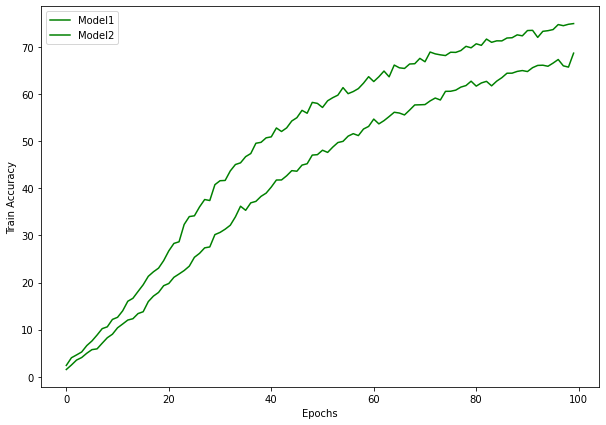

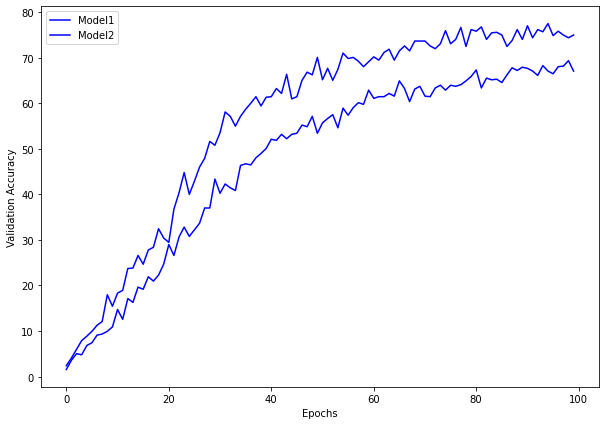

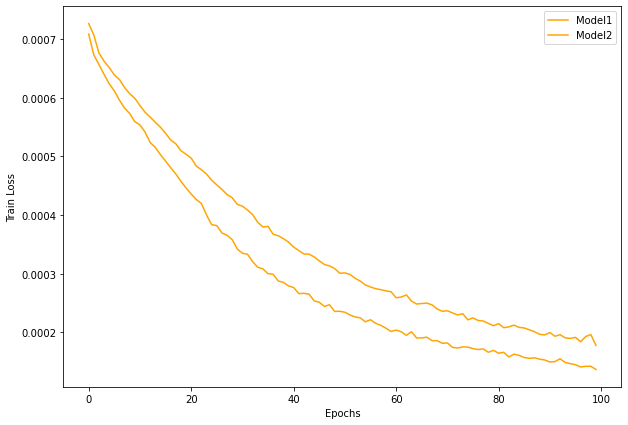

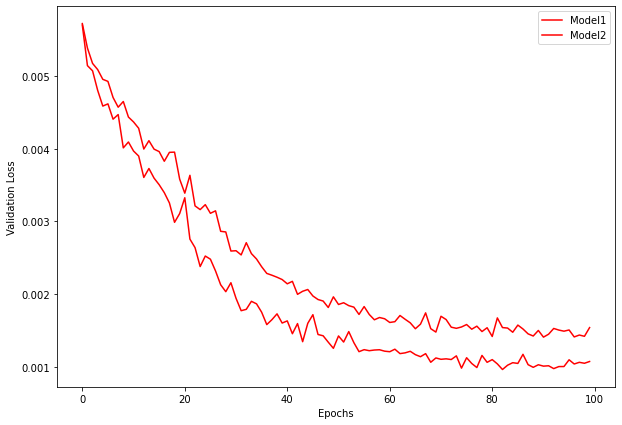

In [143]:
# train the model
train(100, [model_scratch, model_scratch2], criterion_scratch, [optimizer_scratch, optimizer_scratch2], [exp_lr_scheduler, exp_lr_scheduler2])

In [166]:
def test(model, criterion):
    
    # monitor test loss and accuracy
    print("Evaluating model")
    print("-" * 10)
    since = time.time()
    for k,m in enumerate(model):
        m.eval()

        test_loss = 0.
        test_acc = 0.
        correct = 0
        total = 0

        for i, data in enumerate(dataloaders[TEST]):
            images, target = data
            # move to GPU
            images, target = images.to(device), target.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            with torch.no_grad():
                outputs = m(images)
                # calculate the loss
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, target)
                # update average test loss  
                test_loss = test_loss + ((1 / (i + 1)) * (loss.item() - test_loss))

                # compare predictions to true label
                total += target.size(0)
                correct += (preds == target).sum().item()

        avg_loss = test_loss
        test_acc += 100. * correct/total
        print(f"\nModel{k+1} Test Loss: {avg_loss:.6f}")
        print(f"Model{k+1} Test Accuracy: {test_acc:.3f}% {correct}/{total}")
        
    elapsed_time = time.time() - since
    print(f"\nEvaluation completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print('-' * 10)

In [167]:
# call test function    
test([model_scratch, model_scratch2], criterion_scratch)

Evaluating model
----------

Model1 Test Loss: 1.221236
Model1 Test Accuracy: 68.900% 576/836

Model2 Test Loss: 0.911534
Model2 Test Accuracy: 75.120% 628/836

Evaluation completed in 0m 24s
----------
